In [1]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  3.4.2


# Step (1): Load the images and camera parameters. 
This is the same as task 2 step (1). Note that the images are loaded in grayscale or converted to grayscale after loading. Otherwise the ORB feature detector will not work in the next step. You will use a pair of images from the two cameras of the stereo camera system, e.g., using "left_0.png" and "right_0.png". Several pairs of images of different scenes are provided in the project resource folder. You also need to load the camera parameters including the rotation and translation between the two cameras obtained in task 2.

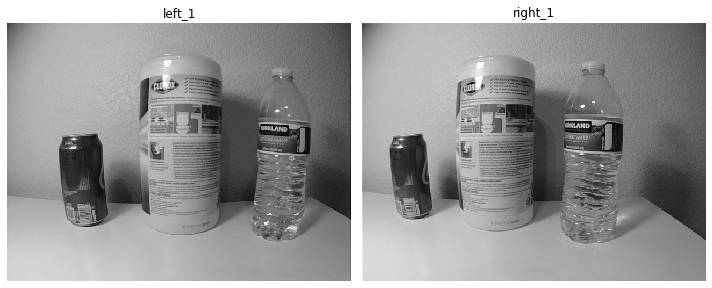

In [2]:
# 0 for grayscale
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_3_and_4/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_3_and_4/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

s = cv2.FileStorage('../task_1/calibrated_camera_parameters.xml', cv2.FileStorage_READ)

mtx_left = s.getNode('mtx_left').mat()
distCoeffs_left = s.getNode('distCoeffs_left').mat()

mtx_right = s.getNode('mtx_right').mat()
distCoeffs_right = s.getNode('distCoeffs_right').mat()
s.release()

s = cv2.FileStorage('../../parameters/stereo_rectification.xml', cv2.FileStorage_READ)
R = s.getNode('R').mat()
T = s.getNode('T').mat()
E = s.getNode('E').mat()
F = s.getNode('F').mat()

R1 = s.getNode('R1').mat()
R2 = s.getNode('R2').mat()
P1 = s.getNode('P1').mat()
P2 = s.getNode('P2').mat()
Q = s.getNode('Q').mat()
roi1 = s.getNode('roi1').mat()
roi2 = s.getNode('roi2').mat()


# Step (2): Detect features. 

## First, undistort the images, which is the same as task 1 step (4). 

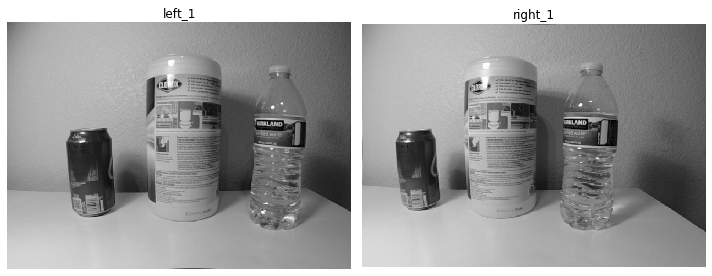

In [3]:
img = left_[0].copy()

# crop the image


for i, img in enumerate(left_):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_left,distCoeffs_left,(w,h),1,(w,h))
    dst = cv2.undistort(img, mtx_left, distCoeffs_left, None, newcameramtx)
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    left_[i] = dst
    
for i, img in enumerate(right_):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_right,distCoeffs_right,(w,h),1,(w,h))
    dst = cv2.undistort(img, mtx_right, distCoeffs_right, None, newcameramtx)
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    right_[i] = dst
    
plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

## Second, detect ORB feature points on each image.
Use the OpenCV library "ORB" class. Third, select a portion of features which are local maximas. Note that each detected feature point has a "response" value associated and this can be used to find the local maxima within a radius of a few pixels. Otherwise, there will be too many detected feature points which can lead to difficulties in the next matching step. An example is shown in Figure 9, which is obtained using the OpenCV library function "drawKeypoints()". 

In [4]:
img_left = left_[0].copy()
img_right = right_[0].copy()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp_left = orb.detect(img_left,None)
kp_right = orb.detect(img_right,None)

# compute the descriptors with ORB
kp_left, des_left = orb.compute(img_left, kp_left)
kp_right, des_right = orb.compute(img_right, kp_right)

## Filter the feature points

In [5]:
import math
def euclidean_dist(pt1, pt2):
    return math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)

def filter_kp(kp, distance=8):
    l = []

    for i in range(len(kp)-2):
        for j in range(i+1,len(kp)-2):
            if euclidean_dist(kp[i].pt,kp[j].pt) < distance:
                # keep the point with the higher response value
                if kp[i].response > kp[j].response:
                    l.append(j)
                else:
                    l.append(i)
                    j = len(kp)

    l = list(dict.fromkeys(l))
    l = sorted(l, reverse=True)
#     print('l: ', l)
    # remove items
    for i in l:
        kp.pop(i)
    
    return kp

In [6]:
len(kp_right)

500

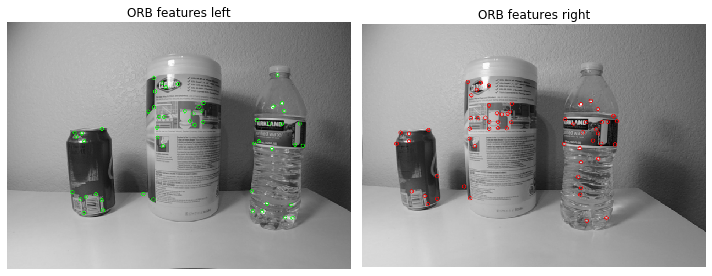

In [7]:
kp_left_filtered = filter_kp(kp_left.copy())
kp_right_filtered = filter_kp(kp_right.copy())


img_left_pts = cv2.drawKeypoints(img_left.copy(), kp_left_filtered, outImage = None, color=(0,255,0))
img_right_pts = cv2.drawKeypoints(img_right.copy(), kp_right_filtered, outImage = None, color=(255,0,0))

plot_figures({'ORB features left':img_left_pts, 'ORB features right':img_right_pts},1,2)

# Step (3): Match features
Once a collection of features are obtained, match features on the two views using the OpenCV library "BFMatcher" class. Then, select a portion of matches based on the matching distance and check the matched features using the epipolar constraints. This means if a match has a pair of feature points, they are located on or very close to each other's epipolar line. Otherwise, it is a false match. Note that checking epipolar constraints requires 2D feature point coordinates on undistorted images. An example of matching results are shown in Figure 10, which is obtained using the OpenCV library function "drawMatches()". Note that there might be false matches even after applying epipolar constraints, especially if similar features appear repeatedly on the images, such as the calibration board. Additionally, when an object does not have distinctive features, such as the top half of the soda can  or the background wall in Figure 10, or the features have different appearances with different view angles, such as the specular reflection of the middle cylinder in Figure 10, feature based depth triangulation does not work. 


In [8]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des_left,des_right)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

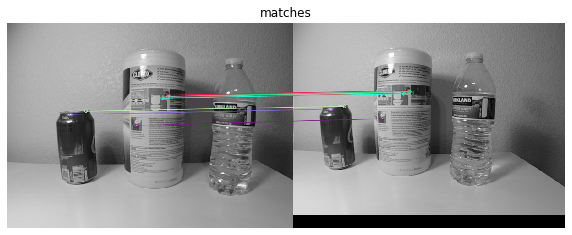

In [9]:
# Draw first 10 matches.
# img_left = left_[0].copy()
# img_right = right_[0].copy()
img3 = cv2.drawMatches(img_left,kp_left,img_right,kp_right,matches[:10], None,flags=2)

plot_figures({'matches':img3})

### Create feature points

In [21]:
matches[0].queryIdx, matches[0].trainIdx

(382, 376)

In [23]:
kp_left[matches[0].queryIdx].pt, kp_right[matches[0].trainIdx].pt

((350.4384460449219, 161.74082946777344),
 (252.97923278808594, 151.37281799316406))

In [25]:
featurePoints_left = []
featurePoints_right = []

for i in range(10):   # extract 10 best feature points
    featurePoints_left.append(kp_left[matches[i].queryIdx].pt)
    featurePoints_right.append(kp_right[matches[i].trainIdx].pt)
    
len(featurePoints_left)

10

In [31]:
np.array(featurePoints_left).transpose().shape

(2, 10)

In [33]:
np.array(featurePoints_left).transpose()[0]

array([350.43844604, 340.89993286, 283.20001221, 350.40002441,
       352.80001831, 139.20001221, 338.40002441, 352.51202393,
       171.99273682, 353.        ])

# Step (4): Triangulate feature points
Once a collection of good matches are obtained, triangulate the pairs of feature points to calculate the 3D coordinates using the OpenCV library function "triangulatePoints()". Note that this requires the projection matrices of both cameras, which can be obtained from the stereo calibration results.

https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#triangulatepoints

cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2[, points4D]) → points4D

In [16]:
pi0 = np.identity(3)
pi0 = np.append(pi0,np.array([[0.],[0.],[0.]]),axis=1)
pi0

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [18]:
np.matmul(mtx_right,pi0)

array([[542.35474306,   0.        , 328.32418897,   0.        ],
       [  0.        , 541.61499607, 246.94729222,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [19]:
mtx_right

array([[542.35474306,   0.        , 328.32418897],
       [  0.        , 541.61499607, 246.94729222],
       [  0.        ,   0.        ,   1.        ]])

In [34]:
points4D = cv2.triangulatePoints(projMatr1=np.matmul(mtx_left,pi0),
                                 projMatr2=np.matmul(mtx_right,pi0),
                                 projPoints1=np.array(featurePoints_left).transpose(), 
                                 projPoints2=np.array(featurePoints_right).transpose(), 
                                 points4D=None)


In [35]:
x = points4D[0]/points4D[3]
y = points4D[1]/points4D[3]
z = points4D[2]/points4D[3]

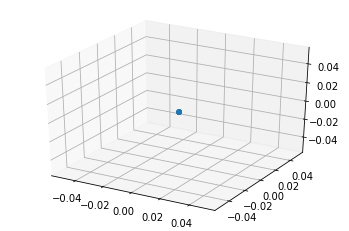

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z)
plt.show()